In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
import pygmt
import os
import pandas as pd
import xarray as xr
import numpy as np
import glob

In [3]:
def compute_hazard_at_poe(levels,values,poe,inv_time):

    rp = -inv_time/np.log(1-poe)
    haz = np.exp( np.interp( np.log(1/rp), np.flip(np.log(values)), np.flip(np.log(levels)) ) )
    return haz

In [4]:
dir_1 = "/work/GNS_oq/NZ_SHM_rev/TAG_workshop/Maps"
#dir_2 = "/work/GNS_oq/NZ_SHM_2010/Hazard_maps/NZ_SHM_all_TRTs/outputs/VS_400"

In [5]:
file = os.path.join(dir_1, "slt_tag_final.grid-NZ_0_1_NB_1_0.csv")

In [6]:
dtype = {'lat':float,'lon':float}
hc = pd.read_csv(file, dtype = dtype)
hc.head(5)

,agg,imt,lat,lon,vs30,poe-0.01,poe-0.02,poe-0.04,poe-0.06,poe-0.08,...,poe-2,poe-2.2,poe-2.4,poe-2.6,poe-2.8,poe-3,poe-3.5,poe-4,poe-4.5,poe-5
0,0.005,PGA,-34.4,172.6,400,0.007206,0.003464,0.001449,0.000712,0.000406,...,7.522470e-09,6.242195e-09,5.507134e-09,5.149755e-09,5.084463e-09,5.084463e-09,5.084463e-09,5.084463e-09,5.084463e-09,5.037957e-09
1,0.1,PGA,-34.4,172.6,400,0.012486,0.006582,0.002455,0.001419,0.000802,...,2.133380e-08,1.780886e-08,1.638709e-08,1.586975e-08,1.549689e-08,1.549689e-08,1.115048e-08,9.275128e-09,8.536738e-09,8.301515e-09
2,0.2,PGA,-34.4,172.6,400,0.014674,0.008054,0.003424,0.001816,0.001167,...,3.681380e-08,2.619994e-08,2.088268e-08,1.910044e-08,1.706715e-08,1.608430e-08,1.549690e-08,1.549689e-08,1.549689e-08,1.549689e-08
3,0.5,PGA,-34.4,172.6,400,0.022762,0.012908,0.006063,0.003519,0.002270,...,1.703917e-07,9.869203e-08,6.764739e-08,4.582042e-08,3.739604e-08,2.919393e-08,2.035029e-08,1.919590e-08,1.919564e-08,1.919564e-08
4,0.8,PGA,-34.4,172.6,400,0.031189,0.017860,0.009695,0.006065,0.004030,...,1.477014e-06,1.130322e-06,7.737966e-07,5.415465e-07,3.866667e-07,2.813519e-07,1.376404e-07,7.549128e-08,4.653667e-08,3.882776e-08


In [7]:
hc.columns

Index(['agg', 'imt', 'lat', 'lon', 'vs30', 'poe-0.01', 'poe-0.02', 'poe-0.04',
       'poe-0.06', 'poe-0.08', 'poe-0.1', 'poe-0.2', 'poe-0.3', 'poe-0.4',
       'poe-0.5', 'poe-0.6', 'poe-0.7', 'poe-0.8', 'poe-0.9', 'poe-1',
       'poe-1.2', 'poe-1.4', 'poe-1.6', 'poe-1.8', 'poe-2', 'poe-2.2',
       'poe-2.4', 'poe-2.6', 'poe-2.8', 'poe-3', 'poe-3.5', 'poe-4', 'poe-4.5',
       'poe-5'],
      dtype='object')

In [8]:
df = hc.drop_duplicates(subset = ['lat', 'lon'])
df.shape

(3618, 34)

In [9]:
levels_str = hc.columns[5:].values
levels = [float(l.split("-")[1]) for l in levels_str]

In [10]:
imt = "PGA"
imt_col1 = imt + "-0.002105"
imt_col2 = imt + "-0.000404"
agg = "mean"
hc = hc.loc[(hc['imt'] == imt) & (hc['agg'] == agg)]
haz_poe1_list = []
haz_poe2_list = []
for i in range(hc.shape[0]):
    values = hc.iloc[i][5:].values.tolist()
    haz_poe1 = compute_hazard_at_poe(levels, values, 0.1, 50.0)
    haz_poe2 = compute_hazard_at_poe(levels, values, 0.02, 50.0)
    haz_poe1_list.append(haz_poe1)
    haz_poe2_list.append(haz_poe2)

df1 = hc.copy()
df1[imt_col1] = haz_poe1_list
df1[imt_col2] = haz_poe2_list

In [11]:
print(min(df1["lat"]))
print(min(df1["lon"]))
print(max(df1["lat"]))
print(max(df1["lon"]))

region = [
    df1.lon.min() - 0.3,
    df1.lon.max() + 0.2,
    df1.lat.min() - 0.2,
    df1.lat.max() + 0.2,
]
print(region)

-47.3
166.4
-34.4
178.6
[166.1, 178.79999999999998, -47.5, -34.199999999999996]


1.275875245372092
0.09402021951645902


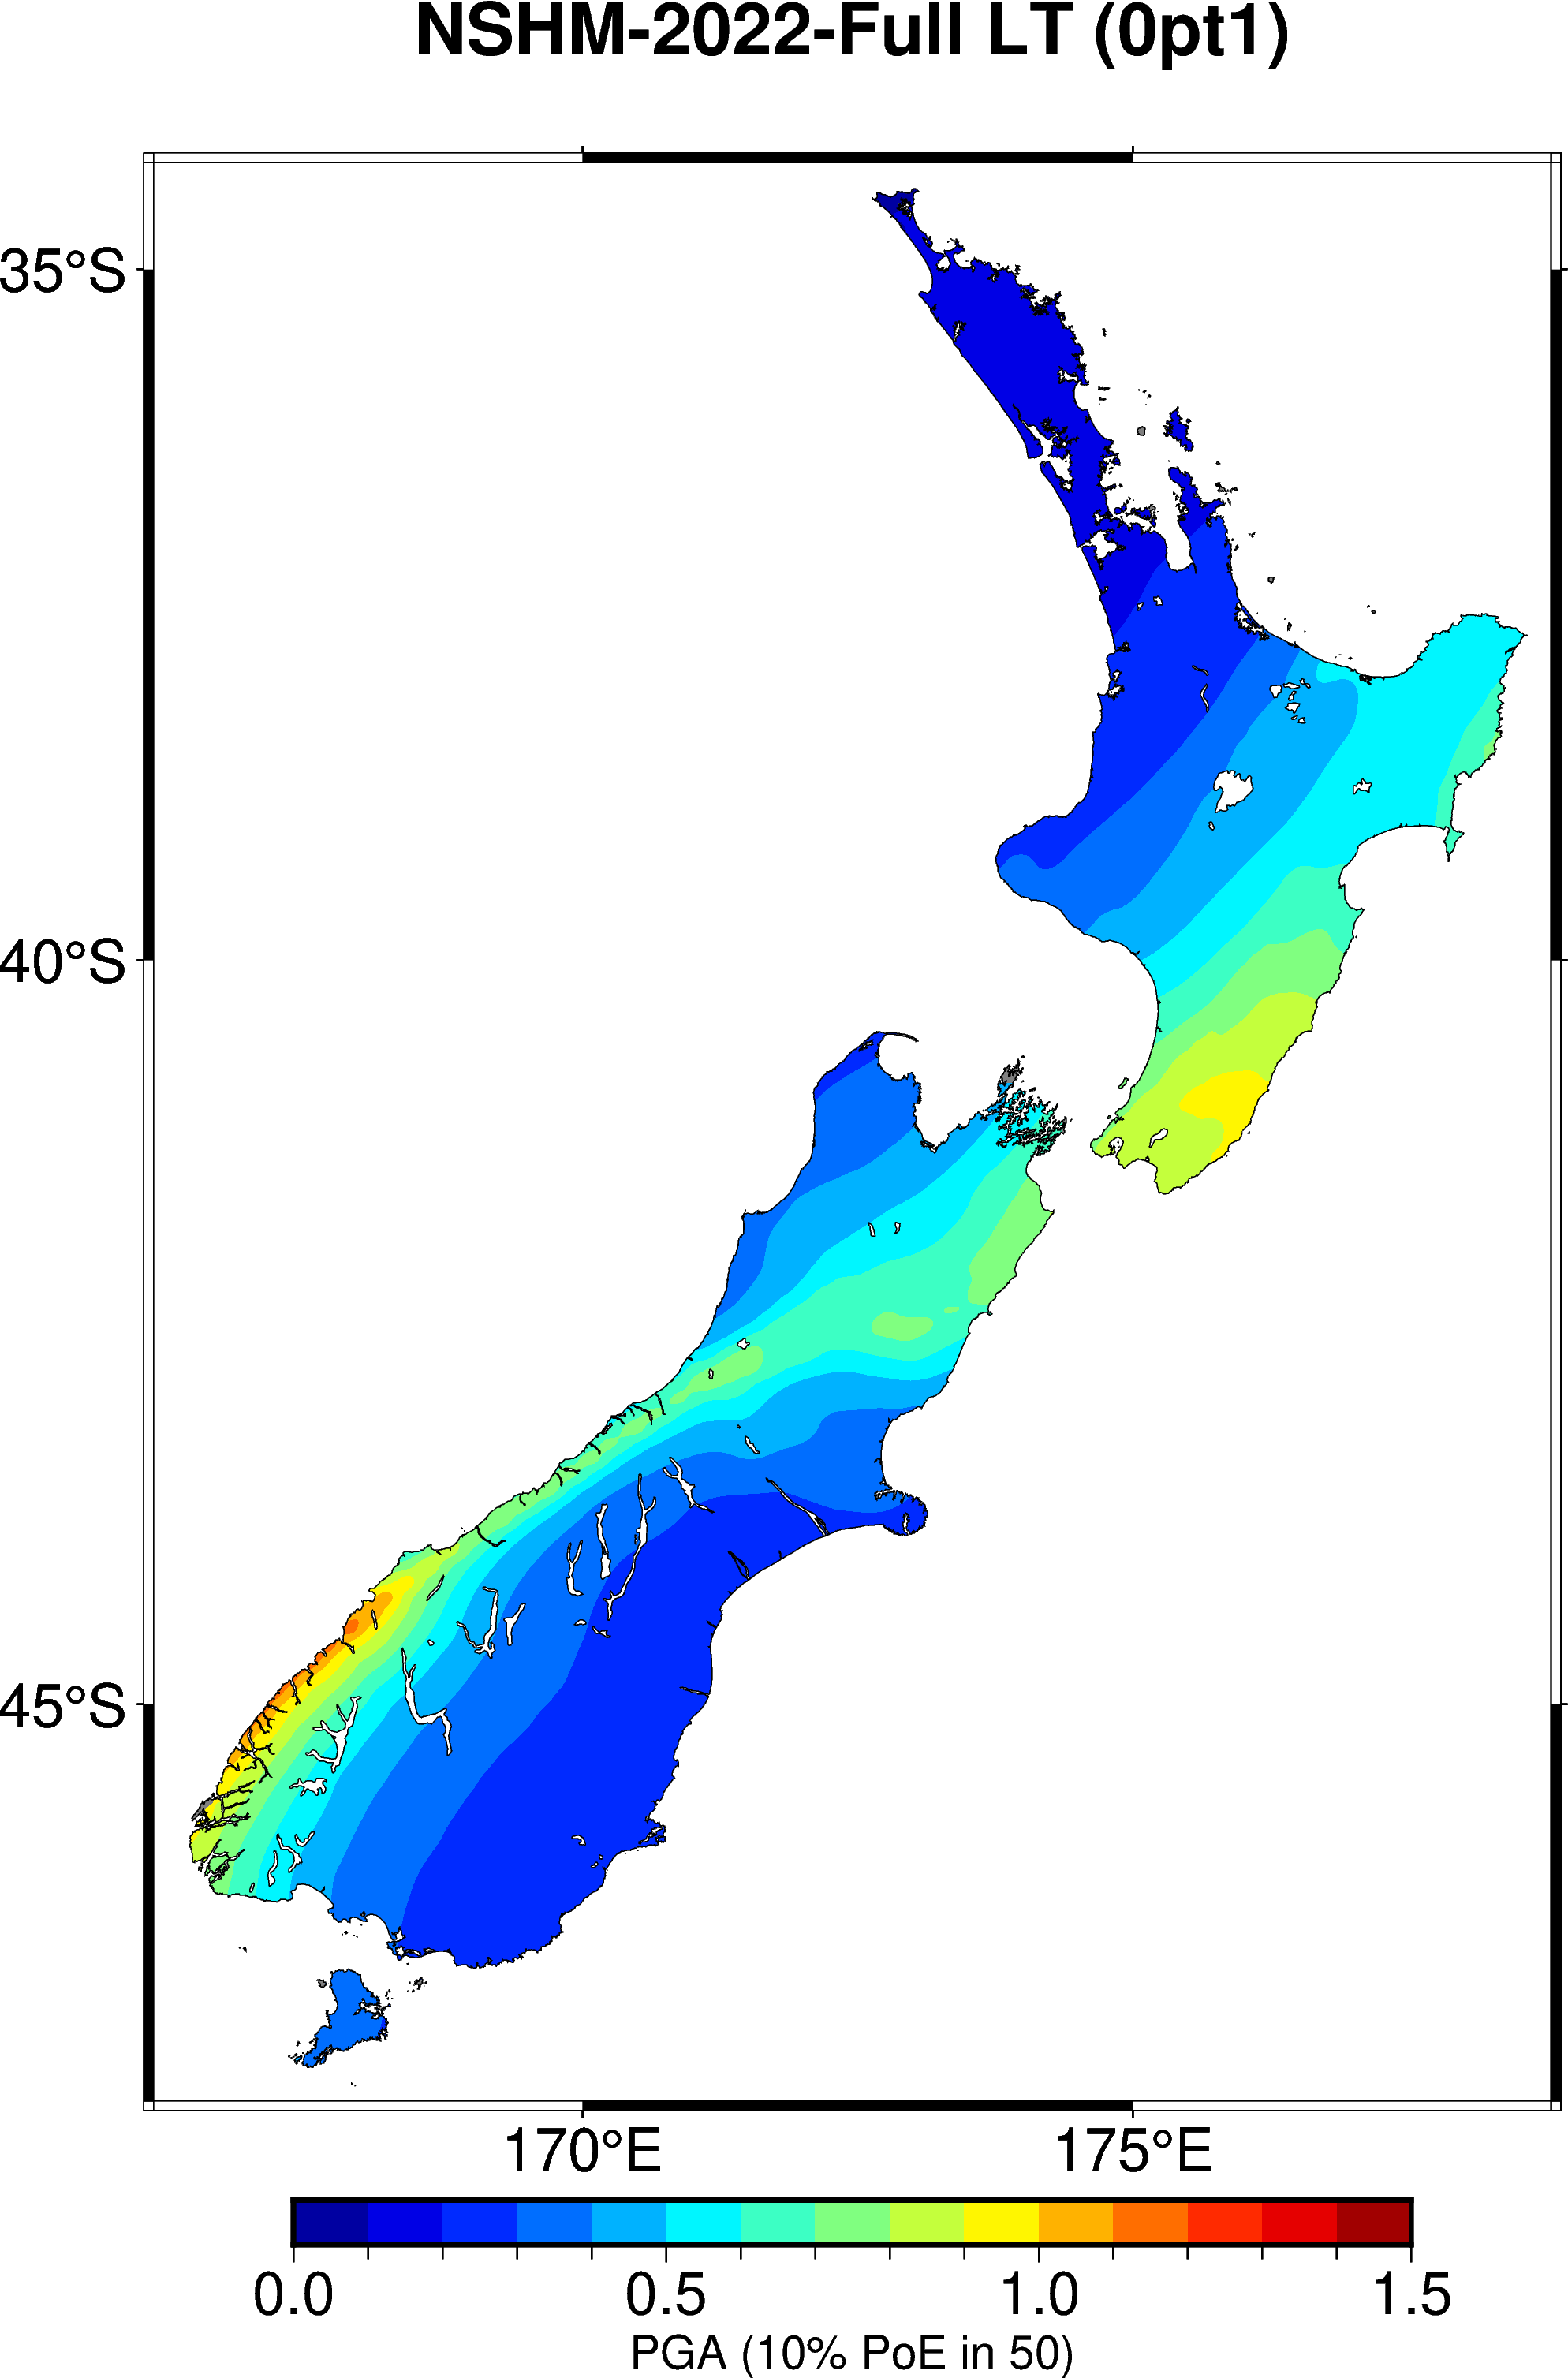

In [12]:
df = df1[["lat", "lon", imt_col1]]
print(df[imt_col1].max())
print(df[imt_col1].min())
df_pv = df.pivot(index="lat", columns="lon")
df_pv = df_pv.droplevel(0, axis=1)
df_pv.head()

grid = xr.DataArray(data=df_pv)

fig = pygmt.Figure()
pygmt.config(FONT_ANNOT_PRIMARY = 18)
pygmt.config(FONT_ANNOT_SECONDARY = 18)

pygmt.makecpt(cmap = "jet", series=[0,1.5,0.1])
fig.grdimage(region = region, grid=grid, projection="M15c", cmap = True, dpi = 300, frame = "a")

fig.coast(shorelines = True, water="white")
fig.basemap(frame=["a", "+tNSHM-2022-Full LT (0pt1)"])
fig.colorbar(frame='x0.5f+l"PGA (10% PoE in 50)"')
fig.show()

2.5222951306843493
0.23000077064182722


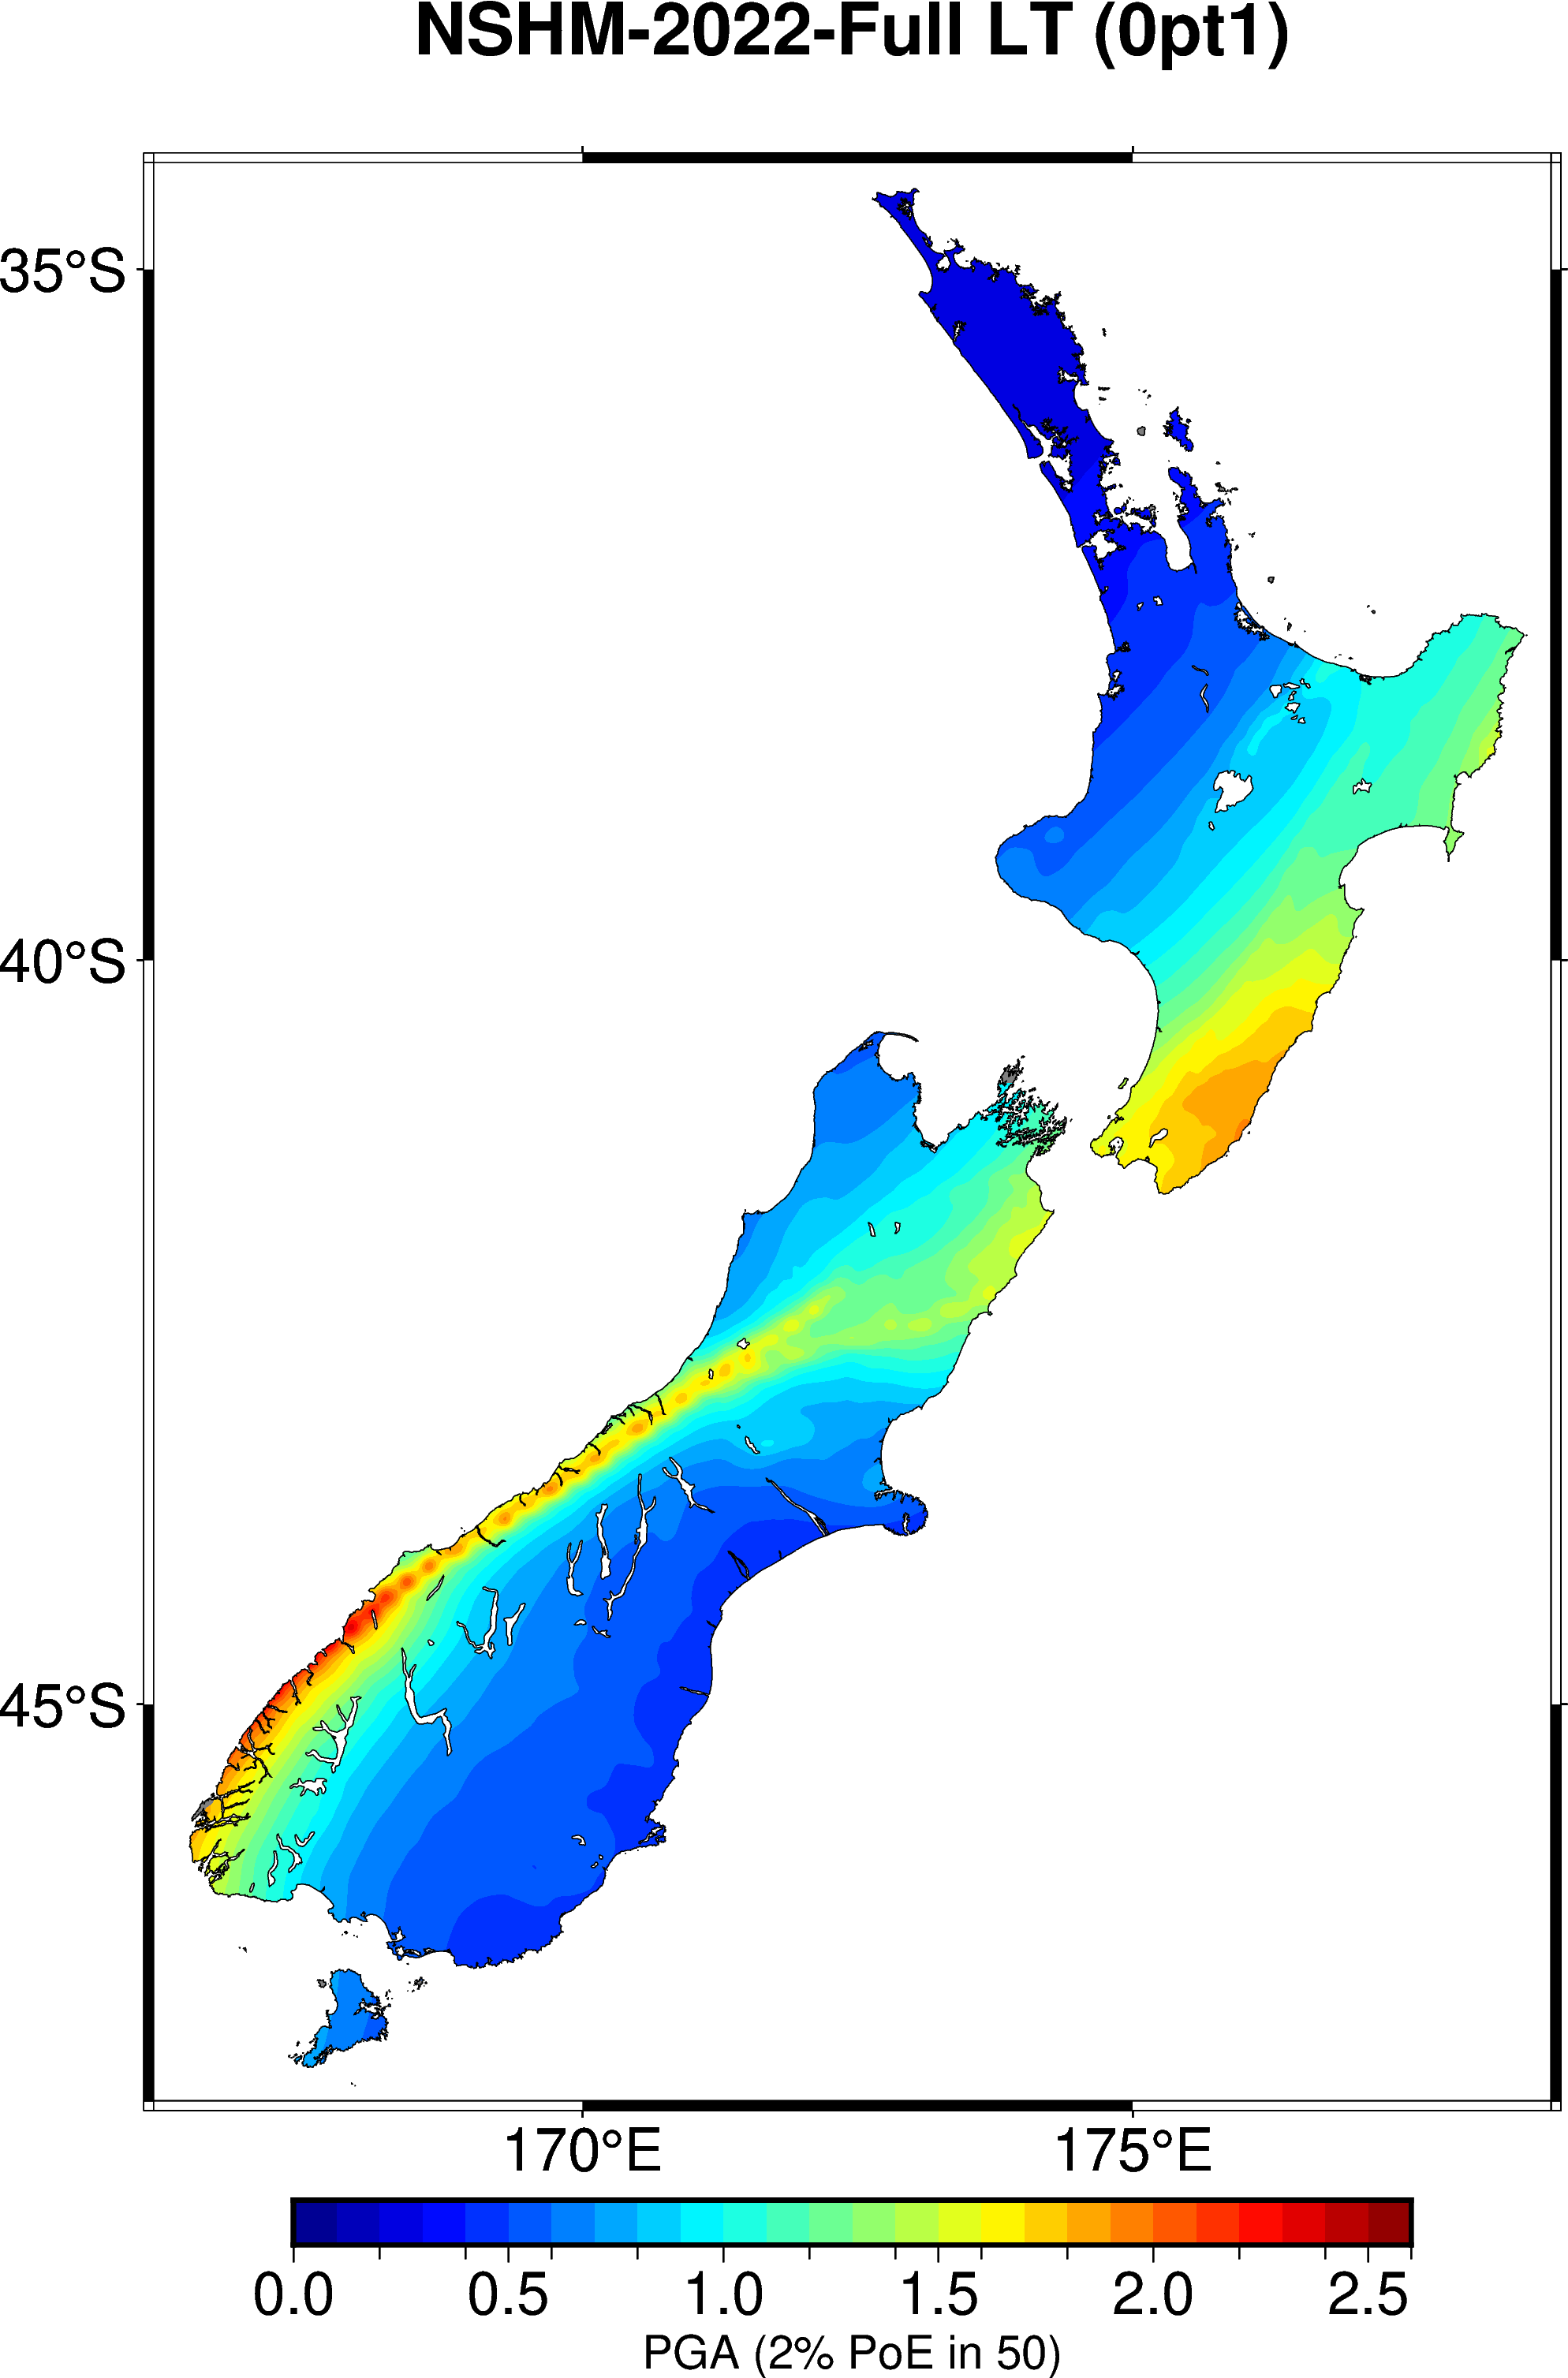

In [13]:
df = df1[["lat", "lon", imt_col2]]
print(df[imt_col2].max())
print(df[imt_col2].min())
df_pv = df.pivot(index="lat", columns="lon")
df_pv = df_pv.droplevel(0, axis=1)
df_pv.head()

grid = xr.DataArray(data=df_pv)

fig = pygmt.Figure()
pygmt.config(FONT_ANNOT_PRIMARY = 18)
pygmt.config(FONT_ANNOT_SECONDARY = 18)

pygmt.makecpt(cmap = "jet", series=[0,2.6,0.1])
fig.grdimage(region = region, grid=grid, projection="M15c", cmap = True, dpi = 300,frame = "a")

fig.coast(shorelines = True, water="white")
fig.basemap(frame=["a", "+tNSHM-2022-Full LT (0pt1)"])
fig.colorbar(frame='x0.5f+l"PGA (2% PoE in 50)"')
fig.show()